
# **Welcome to the eWaterCycle expirement notebook**

This notebook was generated by the eWaterCycle experiment launcher.

We will use GRDC data for comparison between the model simulation and the observations.

In this example notebook we run a hydrology model using [grpc4bmi](https://github.com/eWaterCycle/grpc4bmi), but you can also choose to run your own model, WFLOW or Walrus.


In [28]:
%matplotlib inline  
import os

import cftime
import hydrostats.visual as hv
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr

from ewatercycle.parametersetdb import build_from_urls
#from ewatercycle.observation.grdc import get_grdc_data
from grpc4bmi.bmi_client_docker import BmiClientDocker

## **Setting the input and output configuration**

In [29]:
parameter_set = build_from_urls(
    config_format='ini', config_url='https://github.com/openstreams/wflow/raw/master/examples/wflow_rhine_sbm/wflow_sbm.ini',
    datafiles_format='svn', datafiles_url='https://github.com/openstreams/wflow/trunk/examples/wflow_rhine_sbm',
)

In [30]:
# Write data files required by model to './input'
parameter_set.save_datafiles('./input')

In [31]:
# Overwrite items in config file
# parameter_set.config for this model is a configparser.ConfigParser object
parameter_set.config['model']['configfile'] = '/data/input/wflow_sbm.ini'

In [32]:
# make the old config sbm config work with the lateral_redesign branch
parameter_set.config['summary_avg'] = {}
parameter_set.config['summary_avg']['self.Precipitation'] = 'precip_avg.map'
# add output parameter to plot
parameter_set.config['API']['RiverRunoff'] = '2, m^3/s'

Then it can be saved to the config file:

In [33]:
parameter_set.save_config('input/wflow_sbm.ini')

## **Run docker container that contains model**

In this example we use pcrglob, the model is loaded and initialized according to the configuration file we created in the previous section.

In [34]:
model = BmiClientDocker(image='ewatercycle/wflow-sbm-grpc4bmi:latest', image_port=55555,
                        input_dir="./input",
                        output_dir="./output")

In [35]:
model.initialize('/data/input/wflow_sbm.ini')

In [36]:
tstart = int(model.get_start_time())
tend = int(model.get_end_time())
tstep = int(model.get_time_step())
tunit = model.get_time_units()
tstep_nmbr = (tend - tstart)/tstep 

### Evolve the model and capture variable discharge

Select the variable of our choice and the index of the pixel to record. The pixel index should correspond to the location of the GRDC station that is used to compare the model with.

In [37]:
variable = 'RiverRunoff'
pixel_index = np.array([144])
variable_overtime = []

In [38]:
while model.get_current_time() < tend:
    model.update()
    value_at_pixel = model.get_value_at_indices(variable, pixel_index)[0]
    variable_overtime.append((model.get_current_time(), value_at_pixel))

## **Visualizing the output**

### Plot the variable at the current time as a function of lon/lat

Get the variable values at the current time, coordinates and other useful information for this plot. Since the model just ran until `tend`, this the current time. 

In [16]:
vals = model.get_value(variable)
unit = model.get_var_units(variable)
shape = model.get_grid_shape(model.get_var_grid(variable))
lon = model.get_grid_x(1)
lat = model.get_grid_y(1)
current_date = cftime.num2date(model.get_current_time(),tunit).date()

Reshape the one dimensional list of values to a two dimensional array for plotting and make the plot

[]

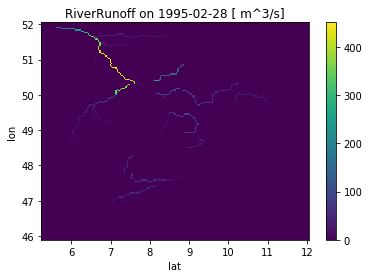

In [17]:
vals_array = np.reshape(ma.masked_where(vals == np.nan, vals), shape)
plt.title(r'{} on {} [{}]'.format(variable,current_date,unit))
plt.pcolormesh(lat,lon,vals_array)
plt.colorbar()
plt.xlabel('lat')
plt.ylabel('lon')
plt.plot()

## **Compare model with observations**

### Convert model output
Convert model time into dates

In [110]:
dstart = cftime.num2date(tstart, tunit).date()
dend = cftime.num2date(tend, tunit).date()
dlist = [cftime.num2date(d[0], tunit).date() for d in variable_overtime]

Convert the (gprcglob) model output into pandas.DataFrame format (required for hydrostat)

In [111]:
var_df = pd.DataFrame(variable_overtime, columns=["sim_time", "simulation"])
var_df = var_df.drop(columns=["sim_time"])
var_df.index = dlist
var_df.index.name = "date"

### Import GRDC data
Load the data using GRDC station id and the start and end date of the model run

In [35]:
station_id = '6335020' 
observations = get_grdc_data(station_id, str(dstart), str(dend))

NameError: name 'get_grdc_data' is not defined

Combine GRDC data with the model output

In [36]:
obs_df = observations.to_dataframe()
var_df["observation"] = obs_df["streamflow"]

NameError: name 'observations' is not defined

Plot hydrograph for simulated and observed values and calculate following metrics (using hydrostats):
 - ME: Mean error
 - NSE: Nash-Sutcliffe Efficiency 
 - SA: Spectral Angle
 
For more information: https://byu-hydroinformatics.github.io/HydroErr/list_of_metrics.html

/data/venv/ewater/lib/python3.7/site-packages/HydroErr/HydroErr.py:2853: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.sum(a) / np.sum(b))
/data/venv/ewater/lib/python3.7/site-packages/HydroErr/HydroErr.py:3604: RuntimeWarning: invalid value encountered in double_scalars
  return np.arccos(a / b)


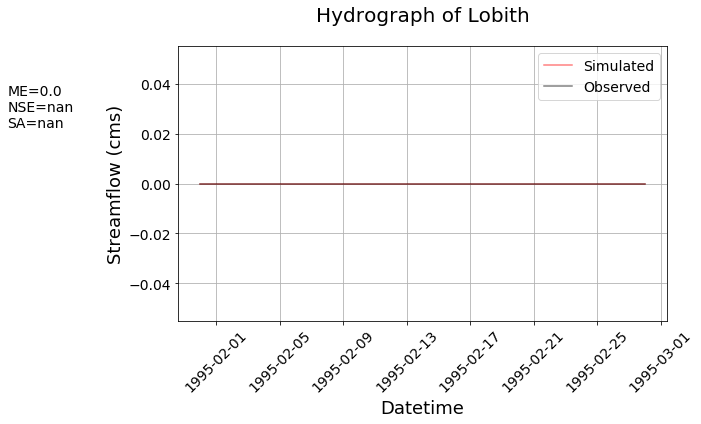

In [112]:
hv.plot(var_df[['simulation', 'simulation']],
      title='Hydrograph of Lobith',
      linestyles=['r-', 'k-'],
      legend=('Simulated', 'Observed'),
      labels=['Datetime', 'Streamflow (cms)'],
      metrics=['ME', 'NSE', 'SA'],
      grid=True)
plt.show()

In [27]:
# Stop the Docker container
del model